# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:11<00:00, 2225.79it/s]


In [23]:
preprocessed_reviews[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

## [3.2] Obtaining the Required DataFrame

In [24]:
type(preprocessed_reviews)

list

In [25]:
print(final.shape)

(160176, 10)


We obtain a list at the end of all the Preprocessing whereas the data frame that we obtained at the end was named 
'final'. Initially I considered 200K datapoints to work upon which got reduced to approx. 160K datapoints after all 
the text processing and data deduplication.

In [26]:
final['Preprocessed_Reviews'] = preprocessed_reviews

Basically I have taken the entire list and added the list as a column to the entire dataframe, such that each value
corresponds to a row in the dataframe. 

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


Now I have a total of approx. 160K rows in the dataframe called 'final', of which I will consider only 100K rows to
be applied to the Logistic Regression Classifier. Also here you have the Unix Timestamp in the data, which is basically the time when the review was posted. 

This makes it possible to carry out Time Based Split of the data instead of random splitting of the data into Train,
CV and Test Datasets. For Time Based Split I will take the oldest of the reviews as the Training Data, the 
intermediate reviews as the CV data and the latest reviews as the Test data. 

In [28]:
final_TBS = final.sort_values('Time')
final_TBS.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


Now the values are sorted on the basis of Time. We know that by default the values are sorted in ascending order. 

First I will remove all the useless columns from my dataframe. The only columns that we are concerned about here in 
this case are the 'Score' & 'Preprocessed_Reviews' (Without carrying out any Feature Engineering). Remaining columns 
in the dataframe are of no use to us. 

In [29]:
df = final_TBS[['Score','Preprocessed_Reviews']]
df.head()

,Score,Preprocessed_Reviews
138706,1,witty little book makes son laugh loud recite ...
138683,1,remember seeing show aired television years ag...
70688,1,bought apartment infested fruit flies hours tr...
1146,1,really good idea final product outstanding use...
1145,1,received shipment could hardly wait try produc...


In [30]:
#considering only the top 100K rows in our dataset
cleandf = df[:100000]

#separately obtaining the 'reviews' as well as the corresponding 'score' class labels
reviews_column = cleandf['Preprocessed_Reviews']
score_column = cleandf['Score']

#obtaining indices for each row in the dataframe. Will be used for joining later
indices = []
for i in range(cleandf.shape[0]):
    indices.append(i)

original_df = pd.DataFrame({'ID': indices, 'Preprocessed_Reviews':reviews_column, 'Score':score_column})
original_df.head()

,ID,Preprocessed_Reviews,Score
138706,0,witty little book makes son laugh loud recite ...,1
138683,1,remember seeing show aired television years ag...,1
70688,2,bought apartment infested fruit flies hours tr...,1
1146,3,really good idea final product outstanding use...,1
1145,4,received shipment could hardly wait try produc...,1


# [4] Data Preperation in the Required Format for LSTM 

* While we are carrying out the Data Preperation, what we need to consider to start with, is to obtain each review as an element in a list. <b> This is a step that is needed to be carried out in order to obtain the entire Vocabulary. </b>
* This is followed by splitting each word in each review as a string instead of taking the entire review list element into consideration, after which we use Counter to count the frequency of occurence of each word in the Vocabulary.
* Now we carry out a ranking of these words such that the ranking of the most occuring word in our vocabulary is 1, followed by the next most occuring word and so on. <b>*This ranking for each word is what is going to be used as an encoding mechanism for each word.* </b>

## [4.1] Data Preperation for Sentiment Classification

In [31]:
#obtaining each row in the 'reviews_column' separately as a part of a list
all_reviews = []
for i in reviews_column:
    all_reviews.append(i)

print(all_reviews[1])
print("="*100)
print ('Number of reviews :', len(all_reviews))

remember seeing show aired television years ago child sister later bought lp day thirty something used series books songs student teaching preschoolers turned whole school purchasing cd along books children tradition lives
Number of reviews : 100000


<b> <font color="black"> Obtaining list of Tuples denoting the Count of Occurence for each word in the Vocabulary :- </font> </b>

In [32]:
#Refer: https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

#obtaining the frequencies for each word in the vocabulary
import collections
from collections import Counter

base_string = ''
all_words = base_string.join(all_reviews)
word_list = all_words.split()

word_count = Counter(word_list)
total_words = len(word_list)
sorted_words = word_count.most_common()

#printing the top 50 words and their corresponding frequencies
print(sorted_words[:50])

[('not', 100009), ('like', 40249), ('good', 31372), ('one', 28723), ('taste', 27696), ('great', 26345), ('would', 25806), ('coffee', 23691), ('flavor', 22874), ('product', 21825), ('tea', 21688), ('no', 18291), ('food', 18075), ('get', 17933), ('love', 15650), ('amazon', 15571), ('really', 15539), ('much', 15141), ('also', 14587), ('use', 13940), ('time', 13786), ('little', 13677), ('find', 13300), ('make', 12902), ('even', 12890), ('best', 12294), ('price', 11980), ('chocolate', 11893), ('well', 11601), ('buy', 11376), ('better', 11339), ('tried', 11298), ('eat', 11045), ('try', 10725), ('sugar', 10242), ('could', 9622), ('dog', 9177), ('found', 9061), ('free', 9052), ('first', 8803), ('bag', 8772), ('water', 8621), ('sweet', 8597), ('made', 8550), ('cup', 8507), ('used', 8364), ('box', 8067), ('way', 8026), ('two', 7984), ('drink', 7930)]


<b> <font color="black"> Obtaining Encoding for each word in the Vocabulary basis the Frequency Ranking:- </font> </b>

In [33]:
# Refer : https://stackoverflow.com/questions/7971618/python-return-first-n-keyvalue-pairs-from-dict
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

#Ranking each word in the vocabulary basis its frequency of occurence
vocab_to_int = {word:i+1 for i, (word,cnt) in enumerate(sorted_words)}
sample_vocab_to_int = take(50,vocab_to_int.items())
print(sample_vocab_to_int)

[('not', 1), ('like', 2), ('good', 3), ('one', 4), ('taste', 5), ('great', 6), ('would', 7), ('coffee', 8), ('flavor', 9), ('product', 10), ('tea', 11), ('no', 12), ('food', 13), ('get', 14), ('love', 15), ('amazon', 16), ('really', 17), ('much', 18), ('also', 19), ('use', 20), ('time', 21), ('little', 22), ('find', 23), ('make', 24), ('even', 25), ('best', 26), ('price', 27), ('chocolate', 28), ('well', 29), ('buy', 30), ('better', 31), ('tried', 32), ('eat', 33), ('try', 34), ('sugar', 35), ('could', 36), ('dog', 37), ('found', 38), ('free', 39), ('first', 40), ('bag', 41), ('water', 42), ('sweet', 43), ('made', 44), ('cup', 45), ('used', 46), ('box', 47), ('way', 48), ('two', 49), ('drink', 50)]


In [34]:
#encoding each word in each review basis its ranking
reviews_int = []
for review in all_reviews:
    encoding = [vocab_to_int.get(w) for w in review.split()]
    reviews_int.append(encoding)
print(reviews_int[0:3])

[[17870, 22, 1333, 69, 349, 5006, 4182, 28456, 1197, 3165, 501, 86, 5816, 10677, 1256, 40974, 2150, 17871, 3811, 15, 142, 1805, 1333, 16313, 28457, 1420, 1333, 1773, 2254, 349, 58, 227, 28456, 3423, 2088], [655, 1816, 1347, 23063, 9149, 71, 272, 957, 1388, 528, 78, 28458, 54, 4183, 75, 46, 4567, 2955, 11085, 3656, 7352, 15100, 745, 103, 985, 719, 7075, 501, 2955, 823, 3717, 2045], [78, 4110, 8301, 144, 3970, 461, 1161, 6144, 59, 3970, 547, 221, 2457, 543, 171, 1, 112, 2474, 1906, 3970, 3165, 779, 924, 152, 4, 2436, 3186, 1062, 34, 798, 7063]]


<b> <font color="black"> Obtaining Dataframe with ID Column as Primary Key and Encoding for each word:- </font> </b>

In [35]:
encoded_df = pd.DataFrame({'ID':indices,'Encoded_value': reviews_int})
encoded_df.head()

,ID,Encoded_value
0,0,"[17870, 22, 1333, 69, 349, 5006, 4182, 28456, ..."
1,1,"[655, 1816, 1347, 23063, 9149, 71, 272, 957, 1..."
2,2,"[78, 4110, 8301, 144, 3970, 461, 1161, 6144, 5..."
3,3,"[17, 3, 527, 2320, 10, 1478, 20, 19925, 1197, ..."
4,4,"[288, 747, 36, 1483, 594, 34, 10, 15, 40978, 7..."


<b> <font color="black"> Combining both of the Dataframes on the ID Column for Visual Purposes:- </font> </b>

In [36]:
combined_df = original_df.merge(encoded_df, on='ID',how='left')
final_df = combined_df[['ID','Preprocessed_Reviews','Encoded_value','Score']]
final_df.head()

,ID,Preprocessed_Reviews,Encoded_value,Score
0,0,witty little book makes son laugh loud recite ...,"[17870, 22, 1333, 69, 349, 5006, 4182, 28456, ...",1
1,1,remember seeing show aired television years ag...,"[655, 1816, 1347, 23063, 9149, 71, 272, 957, 1...",1
2,2,bought apartment infested fruit flies hours tr...,"[78, 4110, 8301, 144, 3970, 461, 1161, 6144, 5...",1
3,3,really good idea final product outstanding use...,"[17, 3, 527, 2320, 10, 1478, 20, 19925, 1197, ...",1
4,4,received shipment could hardly wait try produc...,"[288, 747, 36, 1483, 594, 34, 10, 15, 40978, 7...",1


## [4.2] Obtaining Train & Test Datasets

In [37]:
#Splitting the Train and Test Datasets in the 80:20 ratio
X_Train = final_df['Encoded_value'][:int(final_df.shape[0]*0.8)]
Y_Train = final_df['Score'][:int(final_df.shape[0]*0.8)]

X_Test = final_df['Encoded_value'][int(final_df.shape[0]*0.8):final_df.shape[0]]
Y_Test = final_df['Score'][int(final_df.shape[0]*0.8):final_df.shape[0]]

In [38]:
print(X_Train[1])
print(type(X_Train[1]))
print(len(X_Train[1]))

[655, 1816, 1347, 23063, 9149, 71, 272, 957, 1388, 528, 78, 28458, 54, 4183, 75, 46, 4567, 2955, 11085, 3656, 7352, 15100, 745, 103, 985, 719, 7075, 501, 2955, 823, 3717, 2045]
<class 'list'>
32


# [5] Building LSTM Models

In [39]:
# LSTM for sequence classification in the Amazon Fine Food Reviews dataset
import numpy
import keras
from keras import optimizers
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras.layers import Bidirectional

# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


<b> <font color="black"> Handling 'None' Values in the Encoding:- </font> </b>

In [40]:
lists_with_None = []
with_None=[]
for k in range(len(X_Train)):
    b = all(isinstance(x, int) for x in X_Train[k])
    if b is not True:
        lists_with_None.append(k)
        with_None.append(X_Train[k])
        
X_Train_final=[]
for k in X_Train:
    X_Train_final.append(list(filter(None,k)))

X_Test_final=[]
for k in X_Test:
    X_Test_final.append(list(filter(None,k)))

<b> <font color="black"> Padding the Input Sentences to fix the Input Size:- </font> </b>

In [41]:
# truncate and/or pad input sequences
max_review_length = 500

X_Train_final = sequence.pad_sequences(X_Train_final, maxlen=max_review_length)
X_Test_final = sequence.pad_sequences(X_Test_final, maxlen=max_review_length)

print(X_Train.shape)
print(X_Train[1])

(80000,)
[655, 1816, 1347, 23063, 9149, 71, 272, 957, 1388, 528, 78, 28458, 54, 4183, 75, 46, 4567, 2955, 11085, 3656, 7352, 15100, 745, 103, 985, 719, 7075, 501, 2955, 823, 3717, 2045]


## [5.1] Model 1 : Single LSTM Layer 

<h4> [5.1.1] Constructing the Neural Network </h4>

In [42]:
# Creating the model
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

top_words = 132432
embedding_vector_length = 32

model1 = Sequential()
model1.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model1.add(LSTM(100))

model1.add(Dense(1, activation='sigmoid'))
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           4237856   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,291,157
Trainable params: 4,291,157
Non-trainable params: 0
_________________________________________________________________
None


<b> <font color="black">[5.1.2] Running the Model on Train & Test Datasets for 10 Epochs </font> </b>

In [45]:
batch_size= 64
epochs=10

model1.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=[keras.metrics.AUC(),
                                                                                         'accuracy'])
M1_history = model1.fit(X_Train_final, Y_Train, batch_size=batch_size, epochs=epochs, verbose=1, 
                        validation_data=(X_Test_final, Y_Test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 952s 12ms/step - loss: 0.2294 - auc_1: 0.9164 - accuracy: 0.9122 - val_loss: 0.2084 - val_auc_1: 0.9472 - val_accuracy: 0.9159
Epoch 2/10
80000/80000 [==============================] - 929s 12ms/step - loss: 0.1494 - auc_1: 0.9665 - accuracy: 0.9440 - val_loss: 0.2069 - val_auc_1: 0.9475 - val_accuracy: 0.9179
Epoch 3/10
80000/80000 [==============================] - 936s 12ms/step - loss: 0.1164 - auc_1: 0.9789 - accuracy: 0.9577 - val_loss: 0.2198 - val_auc_1: 0.9438 - val_accuracy: 0.9178
Epoch 4/10
80000/80000 [==============================] - 942s 12ms/step - loss: 0.0915 - auc_1: 0.9860 - accuracy: 0.9679 - val_loss: 0.2324 - val_auc_1: 0.9390 - val_accuracy: 0.9101
Epoch 5/10
80000/80000 [==============================] - 942s 12ms/step - loss: 0.0699 - auc_1: 0.9914 - accuracy: 0.9760 - val_loss: 0.3401 - val_auc_1: 0.9094 - val_accuracy: 0.9063
Epoch 6/10
80000/80000 [=

<h4> Function to obtain the Training & Test AUC Values against the Number of Epochs</h4>

In [43]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

<b> <font color="black">[5.1.3] Number of Epochs vs Train AUC & Test AUC </font> </b>

Test loss: 0.45523406787402926
Test auc value: 0.8912628889083862
Test accuracy: 0.903249979019165


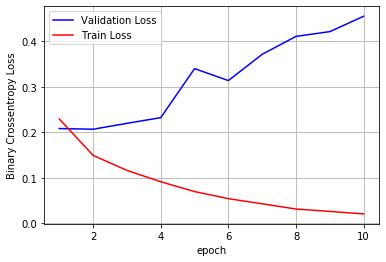

In [50]:
score1 = model1.evaluate(X_Test_final, Y_Test, verbose=0)
print('Test loss:', score1[0])
print('Test auc value:', score1[1])
print('Test accuracy:', score1[2])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.history we will have a list of length equal to number of epochs

vy = M1_history.history['val_loss']
ty = M1_history.history['loss']
plt_dynamic(x, vy, ty, ax)

## [5.2] Model 2 : Stacked LSTM Layers 

<h4> [5.2.1] Constructing the Neural Network </h4>

In [44]:
model2 = Sequential()
model2.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model2.add(LSTM(100, kernel_initializer='he_uniform', dropout=0.4, return_sequences=True))
model2.add(BatchNormalization())
model2.add(LSTM(100,kernel_initializer='he_uniform', dropout=0.4))
model2.add(BatchNormalization())

model2.add(Dense(1, activation='sigmoid'))
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           4237856   
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 100)          400       
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 4,372,357
Trainable params: 4,371,957
Non-trainable params: 400
__________________________________________

<b> <font color="black">[5.2.2] Running the Model on Train & Test Datasets for 10 Epochs </font> </b>

In [47]:
model2.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=[keras.metrics.AUC(),
                                                                                         'accuracy'])
M2_history = model2.fit(X_Train_final, Y_Train, batch_size=batch_size, epochs=epochs, verbose=1, 
                        validation_data=(X_Test_final, Y_Test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 1793s 22ms/step - loss: 0.3111 - auc_1: 0.8472 - accuracy: 0.8698 - val_loss: 0.4087 - val_auc_1: 0.9083 - val_accuracy: 0.8715
Epoch 2/10
80000/80000 [==============================] - 1780s 22ms/step - loss: 0.1921 - auc_1: 0.9437 - accuracy: 0.9259 - val_loss: 0.6663 - val_auc_1: 0.8171 - val_accuracy: 0.8471
Epoch 3/10
80000/80000 [==============================] - 1789s 22ms/step - loss: 0.1570 - auc_1: 0.9624 - accuracy: 0.9412 - val_loss: 0.9134 - val_auc_1: 0.9313 - val_accuracy: 0.5107
Epoch 4/10
80000/80000 [==============================] - 1783s 22ms/step - loss: 0.1304 - auc_1: 0.9737 - accuracy: 0.9524 - val_loss: 0.2030 - val_auc_1: 0.9499 - val_accuracy: 0.9204
Epoch 5/10
80000/80000 [==============================] - 1785s 22ms/step - loss: 0.1120 - auc_1: 0.9800 - accuracy: 0.9596 - val_loss: 0.2040 - val_auc_1: 0.9484 - val_accuracy: 0.9176
Epoch 6/10
80000/800

<b> <font color="black">[5.2.3] Number of Epochs vs Train AUC & Test AUC </font> </b>

Test loss: 0.32536794913969935
Test auc value: 0.9093945622444153
Test accuracy: 0.9133999943733215


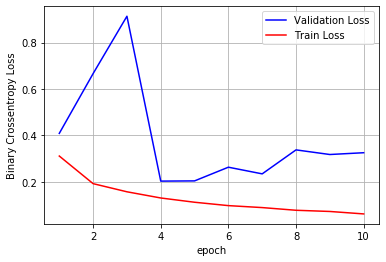

In [48]:
score2 = model2.evaluate(X_Test_final, Y_Test, verbose=0)
print('Test loss:', score2[0])
print('Test auc value:', score2[1])
print('Test accuracy:', score2[2])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.history we will have a list of length equal to number of epochs

vy = M2_history.history['val_loss']
ty = M2_history.history['loss']
plt_dynamic(x, vy, ty, ax)

## [5.3] Model 3 : Stacked LSTM Layers with Bidirectional RNN

<h4> [5.3.1] Constructing the Neural Network </h4>

In [46]:
model3 = Sequential()
model3.add(Embedding(top_words+1, embedding_vector_length, input_length=max_review_length))
model3.add(Bidirectional(LSTM(100, kernel_initializer='he_uniform', dropout=0.4, return_sequences=True)))
model3.add(BatchNormalization())
model3.add(Bidirectional(LSTM(100,kernel_initializer='he_uniform', dropout=0.4)))
model3.add(BatchNormalization())

model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           4237856   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 200)          106400    
_________________________________________________________________
batch_normalization_3 (Batch (None, 500, 200)          800       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 4,586,857
Trainable params: 4,586,057
Non-trainable params: 800
__________________________________________

<b> <font color="black">[5.3.2] Running the Model on Train & Test Datasets for 10 Epochs </font> </b>

In [49]:
batch_size= 64
epochs=10

model3.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=[keras.metrics.AUC(),
                                                                                         'accuracy'])
M3_history = model3.fit(X_Train_final, Y_Train, batch_size=batch_size, epochs=epochs, verbose=1, 
                        validation_data=(X_Test_final, Y_Test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 3365s 42ms/step - loss: 0.2965 - auc_1: 0.8613 - accuracy: 0.8766 - val_loss: 0.2535 - val_auc_1: 0.9353 - val_accuracy: 0.9080
Epoch 2/10
80000/80000 [==============================] - 3599s 45ms/step - loss: 0.1814 - auc_1: 0.9498 - accuracy: 0.9305 - val_loss: 0.2530 - val_auc_1: 0.9475 - val_accuracy: 0.8940
Epoch 3/10
80000/80000 [==============================] - 3514s 44ms/step - loss: 0.1497 - auc_1: 0.9659 - accuracy: 0.9448 - val_loss: 0.2178 - val_auc_1: 0.9472 - val_accuracy: 0.9175
Epoch 4/10
80000/80000 [==============================] - 3371s 42ms/step - loss: 0.1268 - auc_1: 0.9748 - accuracy: 0.9534 - val_loss: 1.7704 - val_auc_1: 0.8591 - val_accuracy: 0.1699
Epoch 5/10
80000/80000 [==============================] - 3531s 44ms/step - loss: 0.1124 - auc_1: 0.9803 - accuracy: 0.9593 - val_loss: 0.6061 - val_auc_1: 0.9395 - val_accuracy: 0.7533
Epoch 6/10
80000/800

<b> <font color="black">[5.3.3] Number of Epochs vs Train AUC & Validation AUC </font> </b>

Test loss: 0.3181260586164892
Test auc value: 0.9163286089897156
Test accuracy: 0.9167500138282776


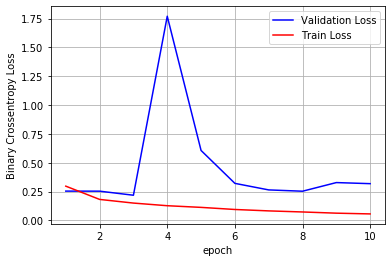

In [50]:
score3 = model3.evaluate(X_Test_final, Y_Test, verbose=0)
print('Test loss:', score3[0])
print('Test auc value:', score3[1])
print('Test accuracy:', score3[2])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the parameter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.history we will have a list of length equal to number of epochs

vy = M3_history.history['val_loss']
ty = M3_history.history['loss']
plt_dynamic(x, vy, ty, ax)

# [6] Conclusion

The Amazon Fine Food Reviews Dataset consists of Reviews and their corresponding polarities ie whether the review is positive or negative. We have already tried various Machine Learning models on the Amazon Fine Food Reviews Dataset, and now we will proceed with Deep Learning Modelling for the same. 

LSTMs make sure that our Long Term Dependecies for the review polarities are taken care of. Also, LSTMs are a great idea to implement because LSTMs take into account the sequence information of the sentences, something that is very important but we have ignored so far in the Machine Learning Text Featurizations that we applied such as BOW, TFIDF, and Word2Vec. But in order to build the LSTM Models we need to first carry out Data Preparation in the format needed for LSTMs. 

We are considering a total of 200K reviews to start with, because of computational limitations which after deduplication results in approximately 160K reviews. Out of these, we only consider 100K reviews where we split the early 80K Reviews (basis time) into the Train Data and the remaining 20K reviews as the Test Dataset {Our Metrics should improve even further if we increase our Train and Test Dataset Sizes}. First, we consider the entire vocabulary and then obtain the frequency of occurence for each word in the vocabulary, on the basis of which each word is ranked. This Ranking is what is used to encode the Reviews in the numerical format. 

After this data preperation is completed, we build LSTM Models on top of it. First we build a single layer LSTM with 100 units (dimensionality of the output space) on top of which we measure the metrics of binary log loss, AUC Value as well as Accuracy. We give the highest preference for the Test AUC Values because Accuracy can be easily skewed in our case towards the majority class in our case : because our dataset is imbalanced. This is followed by Stacked LSTM with a total of 2 layers and then Bidirectional RNN. Again, we consider Adam as the optimizer for our task.

As expected from the results that are summarised below, the stacked Bidirectional RNN works very well and better than the other 2 models because it even takes into consideration the dependency of the words coming afterwards. The summary of each of the metrics obtained is as follows :

In [47]:
from prettytable import PrettyTable

x=PrettyTable()
x.field_names=["Model","Model Type","Test Log Loss","Test AUC","Test Accuracy"]

print ("Metrics for different LSTM Architectures after 10 Epochs:")
print("="*100)

x.add_row(["Model 1","Single layer LSTM", "0.455","0.891","90.32%"])
x.add_row(["Model 2","Stacked LSTM", "0.325","0.909","91.33%"])
x.add_row(["Model 3","Stacked Bidirectional RNN", "0.318","0.916","91.68%"])

print(x)

Metrics for different LSTM Architectures after 10 Epochs:
+---------+---------------------------+---------------+----------+---------------+
|  Model  |         Model Type        | Test Log Loss | Test AUC | Test Accuracy |
+---------+---------------------------+---------------+----------+---------------+
| Model 1 |     Single layer LSTM     |     0.455     |  0.891   |     90.32%    |
| Model 2 |        Stacked LSTM       |     0.325     |  0.909   |     91.33%    |
| Model 3 | Stacked Bidirectional RNN |     0.318     |  0.916   |     91.68%    |
+---------+---------------------------+---------------+----------+---------------+
